# Entrega Final
---

- **Autores**: Amalia Martín y Carlos Toro

## Objetivos

El objetivo de esta practica es implementar todo lo aprendido a lo largo de este módulo, para ello necesitaremos diseñar e implementar un sistema automático que:
- Entrene, evalúe y compare distintos modelos de clasificación binaria
- Seleccione el mejor modelo según una métrica principal, además de ofrecer una visión de
  otras secundarias.
- Automatice el flujo completo desde los datos hasta la inferencia.


## 1º Importacion de Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_diabetes, load_iris, load_wine
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    plot_tree
)
from typing import List, Optional, Tuple, Union
from xgboost import XGBClassifier, XGBRegressor

### Dataset
---

In [249]:
PATH_DIRECTORIO_DATOS = "../data"

In [250]:
PATH_DATASET_HOTEL = f"{PATH_DIRECTORIO_DATOS}/dataset_practica_final.csv"

In [251]:
# Cargamos los datos
df_hotel = pd.read_csv(PATH_DATASET_HOTEL)

In [252]:
# Eliminamos las siguientes columnas
df_hotel_preprocessed = df_hotel.drop(columns=['hotel','arrival_date_year','arrival_date_month','arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights','children','babies','meal','country','market_segment','distribution_channel','is_repeated_guest','previous_bookings_not_canceled','reserved_room_type','assigned_room_type','booking_changes','agent','company','days_in_waiting_list','required_car_parking_spaces','reservation_status','reservation_status_date'])

In [253]:
df_hotel_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   is_canceled                119390 non-null  int64  
 1   lead_time                  119390 non-null  int64  
 2   stays_in_week_nights       119390 non-null  int64  
 3   adults                     119390 non-null  int64  
 4   previous_cancellations     119390 non-null  int64  
 5   deposit_type               119390 non-null  object 
 6   customer_type              119390 non-null  object 
 7   adr                        119390 non-null  float64
 8   total_of_special_requests  119390 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 8.2+ MB


In [254]:
# Verificamos si hay valores vacíos en el df
df_hotel_preprocessed.isna().sum()

is_canceled                  0
lead_time                    0
stays_in_week_nights         0
adults                       0
previous_cancellations       0
deposit_type                 0
customer_type                0
adr                          0
total_of_special_requests    0
dtype: int64

In [255]:
df_hotel_preprocessed.columns

Index(['is_canceled', 'lead_time', 'stays_in_week_nights', 'adults',
       'previous_cancellations', 'deposit_type', 'customer_type', 'adr',
       'total_of_special_requests'],
      dtype='object')

In [256]:
df_hotel_preprocessed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
adr,119390.0,101.831122,50.535790,-6.38,69.29,94.575,126.0,5400.0
total_of_special_requests,119390.0,0.571363,0.792798,0.00,0.00,0.000,1.0,5.0


In [257]:
print(f"Nulls restantes:\n{df_hotel_preprocessed.isnull().sum().sort_values(ascending=False)}")

Nulls restantes:
is_canceled                  0
lead_time                    0
stays_in_week_nights         0
adults                       0
previous_cancellations       0
deposit_type                 0
customer_type                0
adr                          0
total_of_special_requests    0
dtype: int64


In [258]:
# Lista de los nombres de las columnas
lista_columnas_independientes = df_hotel_preprocessed.drop(columns = target_column).columns.to_list()

In [259]:
lista_columnas_independientes

['lead_time',
 'stays_in_week_nights',
 'adults',
 'previous_cancellations',
 'deposit_type',
 'customer_type',
 'adr',
 'total_of_special_requests']

In [261]:
# Almacenamos la varaible target
target_column = 'is_canceled'
df_hotel_preprocessed[target_column] = df_hotel_preprocessed[target_column].astype(str)

In [262]:
df_hotel_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   is_canceled                119390 non-null  object 
 1   lead_time                  119390 non-null  int64  
 2   stays_in_week_nights       119390 non-null  int64  
 3   adults                     119390 non-null  int64  
 4   previous_cancellations     119390 non-null  int64  
 5   deposit_type               119390 non-null  object 
 6   customer_type              119390 non-null  object 
 7   adr                        119390 non-null  float64
 8   total_of_special_requests  119390 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 8.2+ MB


## Creación del modelo regresión logística y ajuste

In [266]:
X_hotel = df_hotel_preprocessed.drop(columns=target_column)
y_hotel = df_hotel_preprocessed[target_column]

# Hacemos esto par apoder aplicar el GridSearch ya que no podemos usarlo con str
X_hotel = pd.get_dummies(X_hotel, drop_first=True)


In [267]:
X_train, X_test, y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.5,stratify=y_hotel, random_state=42)

# Verificamos el ratio

In [268]:
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_test.value_counts(normalize=True))


Distribución de clases en el conjunto de entrenamiento:
is_canceled
0    0.629584
1    0.370416
Name: proportion, dtype: float64

Distribución de clases en el conjunto de entrenamiento:
is_canceled
0    0.629584
1    0.370416
Name: proportion, dtype: float64


In [269]:
# Entrenamos un modelo usando GridSearchCV para encontrar los mejores hiperparámetros
dict_parametros = {
    'C' : [0.01,0.1,1,10,100],
    'solver': ['liblinear']
}

modelo_rl = LogisticRegression(max_iter=200, random_state=42)
modelo_rl_cv = GridSearchCV(modelo_rl, dict_parametros, cv = 5, scoring="accuracy")
modelo_rl_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
             scoring='accuracy')

In [270]:
print(f"Mejores hiperparámetros encontrados: {modelo_rl_cv.best_params_}")
print(f"Mejor score obtenido: {modelo_rl_cv.best_score_:.2%}")

Mejores hiperparámetros encontrados: {'C': 0.1, 'solver': 'liblinear'}
Mejor score obtenido: 77.34%


In [271]:
modelo_rl = LogisticRegression(**modelo_rl_cv.best_params_, max_iter=500, random_state=42)
modelo_rl.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=500, random_state=42, solver='liblinear')

## Evaluación del modelo

In [272]:
# Predicción sobre el conjunto de test
y_pred = modelo_rl.predict(X_test)
y_proba = modelo_rl.predict_proba(X_test)[:, 1]

In [273]:
# Mostramos las primeras 5 etiquetas reales, las probabilidades de pertenencia a la clase positiva y las predicciones
print(f"Primeras 5 etiquetas reales: {y_test.iloc[:5].values}")
print(f"Primeras 5 probabilidades: {y_proba[:5]}")
print(f"Primeras 5 predicciones: {y_pred[:5]}")

Primeras 5 etiquetas reales: ['1' '1' '0' '0' '0']
Primeras 5 probabilidades: [0.55950289 0.28644597 0.15156671 0.55012027 0.30639072]
Primeras 5 predicciones: ['1' '0' '0' '1' '0']


In [274]:
list(dict_target_hotel.values())
#Almacenamos el valor en una lista
list_target_hotel = list(dict_target_hotel.values())

In [277]:
# Asegurar que sean enteros
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)
# Obtención de las métricas de evaluación la que más nos interesa en F1-Score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  0.77
Precisión: 0.87
Recall:    0.45
F1-Score:  0.60
AUC:       0.79



In [276]:
# Gracias a la función classification_report podemos obtener un reporte detallado de las métricas de evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84     37583
           1       0.87      0.45      0.60     22112

    accuracy                           0.77     59695
   macro avg       0.81      0.71      0.72     59695
weighted avg       0.79      0.77      0.75     59695



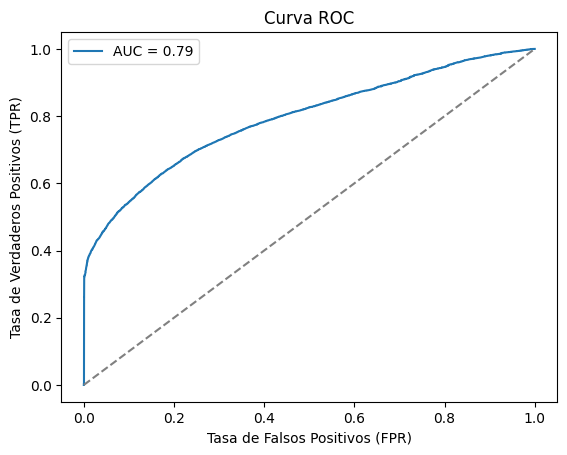

In [279]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

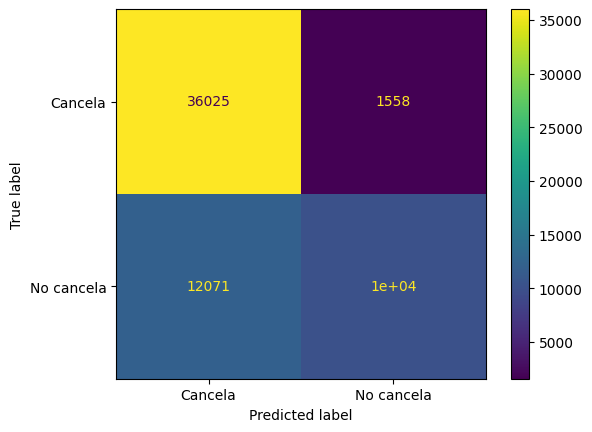

In [278]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancela', 'No cancela'])
disp.plot()
plt.show()

## Creación del modelo arbol de decision

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.2, random_state=42)

modelo_dt = DecisionTreeClassifier(max_depth=3, random_state=42)
modelo_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [293]:
# Hacemos prediccion
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  0.77
Precisión: 0.99
Recall:    0.38
F1-Score:  0.55
AUC:       0.75



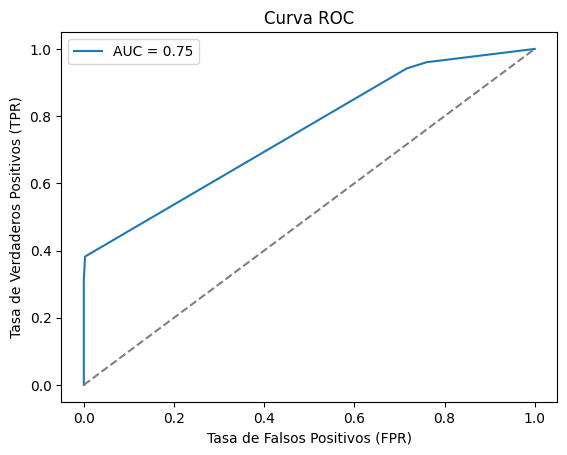

In [294]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

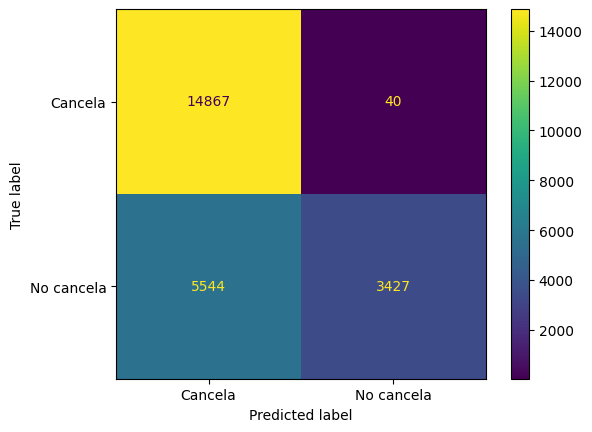

In [295]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancela', 'No cancela'])
disp.plot()
plt.show()

## Creación del modelo RF

In [300]:
# Preparación de los datos para el entrenamiento del modelo
X_train, X_test, y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.2, random_state=42)

# Entrenamiento de un modelo de RandomForest Classifier
modelo_rfc = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [301]:
# Hacemos predicciones sobre el conjunto de test
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")


Accuracy:  0.77
Precisión: 0.99
Recall:    0.38
F1-Score:  0.55
AUC:       0.75



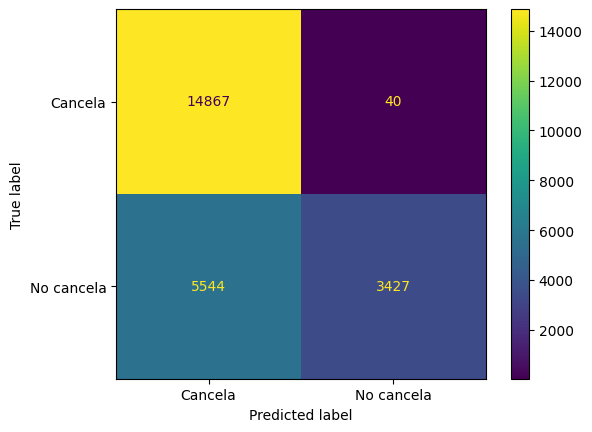

In [303]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancela', 'No cancela'])
disp.plot()
plt.show()

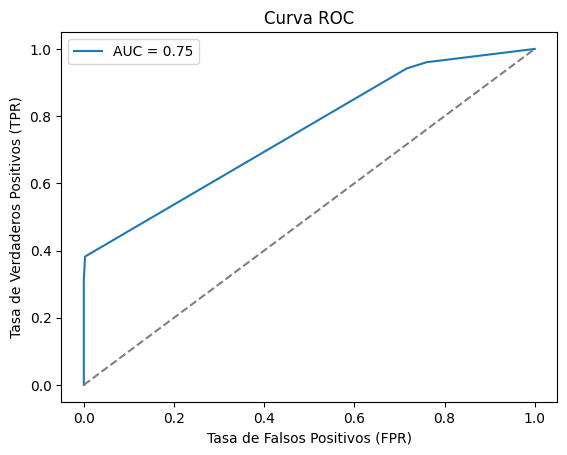

In [304]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()